In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as ssg
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator

plt.rcParams['font.sans-serif'] = ['SimHei']  ###防止无法显示中文并设置黑体
plt.rcParams['axes.unicode_minus'] = False  ###用来正常显示负号

In [2]:
ds = xr.open_dataset('../../data/sst.mnmean.nc')
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2016, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-01-07

In [3]:
# 对冬季ENSO指数进行5点、11点一次、二次平滑
winsst = ds['sst'].loc[ds.time.dt.month.isin([12, 1, 2])].loc['1854-3-01':'2021-11-01', :, :]
winsst

<xarray.DataArray 'sst' (time: 501, lat: 89, lon: 180)>
[8026020 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-12-01 1855-01-01 ... 2021-02-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [4]:
# 把今年的12月和明年的1、2月当作今年的冬季
# 创建一个1854-2020的一维矩阵
win = np.zeros((int(len(winsst.time) / 3), len(winsst.lat), len(winsst.lon)))
temp = np.zeros((len(winsst.lat), len(winsst.lon)))
j = 0
for i in range(len(winsst.time)):
    temp += winsst[i, :, :]
    if (i + 1) % 3 == 0:
        win[j, :, :] = temp / 3
        j += 1
        temp = 0

In [5]:
# 把win转化成 DataArray
win = xr.DataArray(data=win, dims=['time', 'lat', 'lon'], coords={'time': np.arange(1854, 2021, 1),
                                                                  'lat': winsst.lat.data,
                                                                  'lon': winsst.lon.data})
win

<xarray.DataArray (time: 167, lat: 89, lon: 180)>
array([[[-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        [-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        [-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79999983, -1.79999983, -1.79999983, ..., -1.79999983,
         -1.79999983, -1.79999983],
        [-1.79999983, -1.79999983, -1.79999983, ..., -1.79999983,
         -1.79999983, -1.79999983],
        [-1.79999983, -1.79999983, -1.79999983, ..., -1.79999983,
         -1.79999983, -1.79999983],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79999983, -1.79999983, -1.79999983, ..., -1.79999983,
         -1.79999983, -1.79999983],
        [-1.79999983, -1.79999983, -1.79999983, ..., -1.79999983,
         -1.79999983, -1.79999983],
        [-1.79999983, -1.79999983, -1.79999983, ..., -1.79999983,
         -1.79999983, -1.79999983],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time     (time) int32 1854 1855 1856 1857 1858 ... 2016 2017 2018 2019 2020
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [6]:
ENSOwin = win.loc[:, 5:-5, 190:240].mean(dim=['lat', 'lon'], skipna=True)

In [7]:
## 进行平滑操作
## 利用 scipy.signal 的 savgol_filter 函数
### 五点一次、二次平滑
ENSOwin5_1 = ssg.savgol_filter(ENSOwin, 5, 1)
ENSOwin5_2 = ssg.savgol_filter(ENSOwin, 5, 2)

### 十一点一次、二次平滑
ENSOwin11_1 = ssg.savgol_filter(ENSOwin, 11, 1)
ENSOwin11_2 = ssg.savgol_filter(ENSOwin, 11, 2)

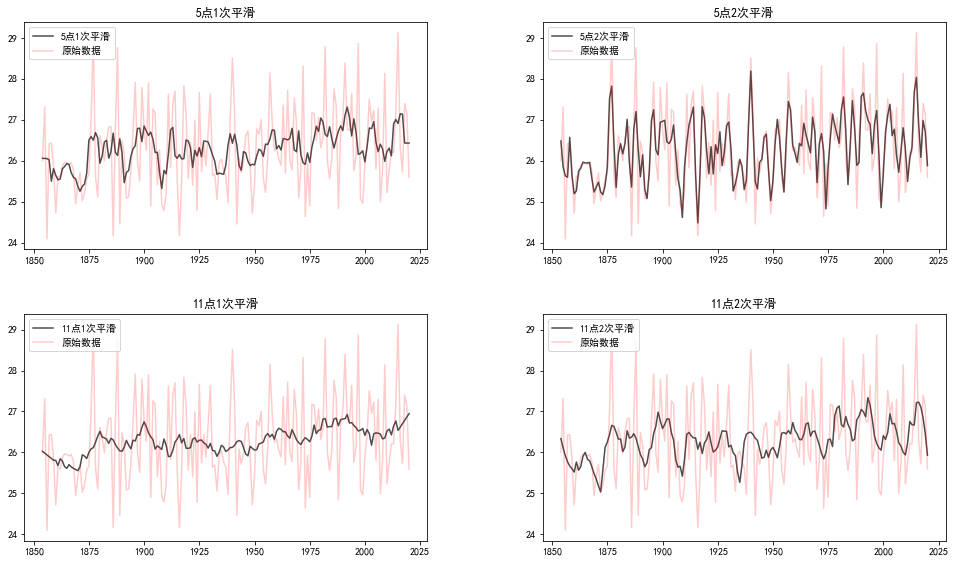

In [8]:
## 绘图
fig = plt.figure(figsize=(16, 9))
ax = fig.add_axes([0.1, 0.1, 0.35, 0.35])
ax2 = fig.add_axes([0.55, 0.1, 0.35, 0.35])
ax3 = fig.add_axes([0.1, 0.55, 0.35, 0.35])
ax4 = fig.add_axes([0.55, 0.55, 0.35, 0.35])

# 标题
ax3.set_title("5点1次平滑")
ax4.set_title("5点2次平滑")
ax.set_title("11点1次平滑")
ax2.set_title("11点2次平滑")

# 绘制
ax.plot(np.arange(1854, 2021), ENSOwin11_1, color="k", alpha=0.7, label='11点1次平滑')
ax.plot(np.arange(1854, 2021), ENSOwin, color="r", alpha=0.2, label='原始数据')
ax2.plot(np.arange(1854, 2021), ENSOwin11_2, color="k", alpha=0.7, label='11点2次平滑')
ax2.plot(np.arange(1854, 2021), ENSOwin, color="r", alpha=0.2, label='原始数据')
ax3.plot(np.arange(1854, 2021), ENSOwin5_1, color="k", alpha=0.7, label='5点1次平滑')
ax3.plot(np.arange(1854, 2021), ENSOwin, color="r", alpha=0.2, label='原始数据')
ax4.plot(np.arange(1854, 2021), ENSOwin5_2, color="k", alpha=0.7, label='5点2次平滑')
ax4.plot(np.arange(1854, 2021), ENSOwin, color="r", alpha=0.2, label='原始数据')
ax.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper left', fontsize=10)
ax3.legend(loc='upper left', fontsize=10)
ax4.legend(loc='upper left', fontsize=10)
# 保存图片
plt.savefig('../../picture/pythonhome/13/qu1.png', dpi=200)

# 第二问

In [9]:
# 计算冬季ENSO指数与全球冬季海温的相关系数并进行显著性检验  t检验
# 对数据进行标准化 距平/标准差
# ENSOwin
ENSOwinbz = (ENSOwin - ENSOwin.mean()) / ENSOwin.std()

# win
winbz = (win - win.mean(dim='time')) / win.std(dim='time', skipna=True)

D:\anaconda\envs\py310\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


# 相关系数显著性检验
- 假设$\rho$=0成立，它服从自由度为n-2 的 t分布
- 给定显著性水平 $\alpha$ 0.05

# 相关系数
$r=\frac{\frac{1}{n}\sum_{i=1}^{n}(X_{i}-\overline{X})(Y_{i}-\overline{Y})}{\frac{1}{n}\sqrt{\sum_{i=1}^{n}(X_{i}-\overline{X})^2}\sqrt{\sum_{i=1}^{n}(Y_{i}-\overline{Y})^2}}$

# 统计量 t
$t=\frac{r\sqrt{n-2}}{\sqrt{1-r^2}}$

In [10]:
# 求相关系数
def xiangguan(x, ds):
    x = x - x.mean()
    y = ds - ds.mean(dim='time')
    x = x.reshape((len(x), 1, 1))
    up = np.sum(x * y, axis=0) / len(x)
    down = (np.sqrt(np.sum(x ** 2)) * np.sqrt(np.sum(y ** 2, axis=0))) / len(x)
    # 相关系数
    r = up / down
    return r

In [11]:
# 冬季ENSO指数与全球冬季海温的相关系数
sstxg = xiangguan(np.array(ENSOwinbz), winbz)

# 进行t检验

t = (sstxg * np.sqrt(len(ENSOwinbz) - 2)) / (np.sqrt(1 - np.power(sstxg, 2)))

In [12]:
t1 = t.where(t > 1.984, np.nan)

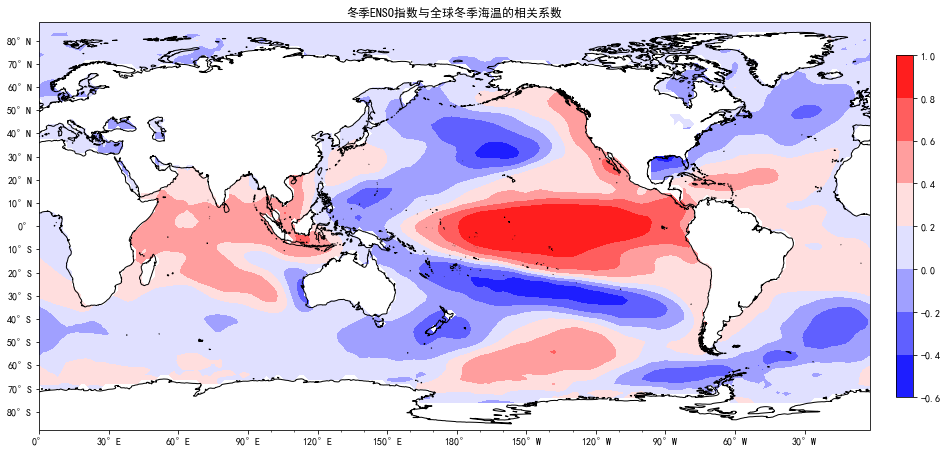

In [13]:
lat = winbz.lat.data
lon = winbz.lon.data
# 相关系数
fig = plt.figure(figsize=(16, 9))
ax = fig.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
ax.coastlines('50m')
ax.set_title('冬季ENSO指数与全球冬季海温的相关系数')
# 标注坐标轴
ax.set_xticks(np.arange(-180, 180 + 10, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90 + 10, 10), crs=ccrs.PlateCarree())
# 设置大小刻度
minorticks = MultipleLocator(10)
majorticks = MultipleLocator(30)
ax.xaxis.set_major_locator(majorticks)
ax.xaxis.set_minor_locator(minorticks)
ax.yaxis.set_minor_locator(minorticks)
# 经纬度格式，把0经度设置不加E和W
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
colorbar = ax.contourf(lon, lat, sstxg, cmap='bwr', transform=ccrs.PlateCarree())
plt.colorbar(colorbar, extendrect='True', pad=0.03, fraction=0.04, shrink=0.7)

# 保存图片
plt.savefig('../../picture/pythonhome/13/qu2.png', dpi=200)

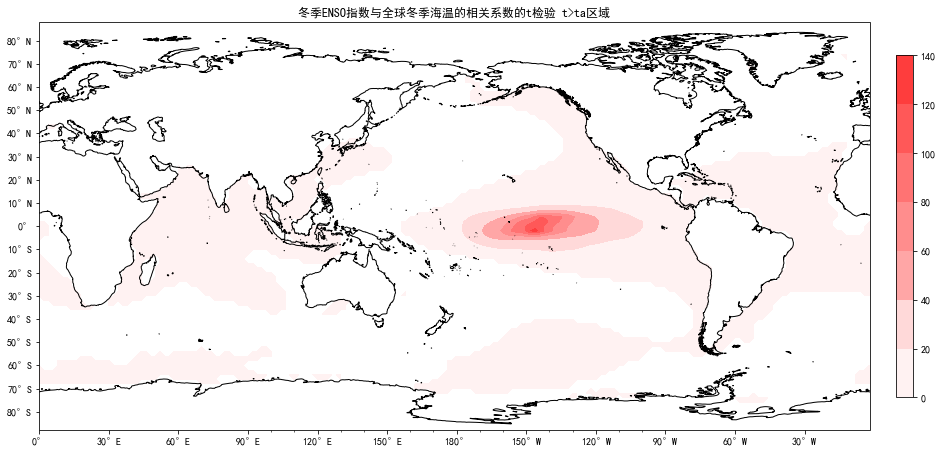

In [14]:
# t检验
fig = plt.figure(figsize=(16, 9))
ax = fig.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
ax.coastlines('50m')
ax.set_title('冬季ENSO指数与全球冬季海温的相关系数的t检验 t>ta区域')
# 标注坐标轴
ax.set_xticks(np.arange(-180, 180 + 10, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90 + 10, 10), crs=ccrs.PlateCarree())
# 设置大小刻度
minorticks = MultipleLocator(10)
majorticks = MultipleLocator(30)
ax.xaxis.set_major_locator(majorticks)
ax.xaxis.set_minor_locator(minorticks)
ax.yaxis.set_minor_locator(minorticks)
# 经纬度格式，把0经度设置不加E和W
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
colorbar = ax.contourf(lon, lat, t1,
                       colors=['#fff2f2', '#ffd9d9', '#ffa6a6', '#ff8d8d', '#ff7373', '#ff5858', '#fe3d3d'],
                       transform=ccrs.PlateCarree())
plt.colorbar(colorbar, extendrect='True', pad=0.03, fraction=0.04, shrink=0.7)

# 保存图片
plt.savefig('../../picture/pythonhome/13/qu22.png', dpi=200)

# 第三问

In [15]:
#  对El Nino和La Nina年的我国冬季气温进行合成分析，并进行显著性检验
#  1984-2021年
#  ElNino 年
nino_year = np.array(
    [1951, 1957, 1963, 1965, 1968, 1972, 1976, 1977, 1979, 1982, 1986, 1991, 1994, 1997, 2002, 2004, 2006, 2009, 2014])

# Lanina 年
nina_year = np.array([1950, 1954, 1964, 1970, 1973, 1975, 1984, 1988, 1995, 1998, 2000, 2007, 2010, 2011])

In [16]:
# 读取气温数据
air = xr.open_dataset('../../data/air.mon.mean.nc')['air']
air = air.loc[air.time.dt.month.isin([12, 1, 2])].loc['1948-12-01':'2022', :, :]
air

<xarray.DataArray 'air' (time: 222, lat: 73, lon: 144)>
[2333664 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-12-01 1949-01-01 ... 2022-02-01
Attributes:
    long_name:     Monthly Mean Air Temperature at sigma level 0.995
    valid_range:   [-2000.  2000.]
    units:         degC
    precision:     1
    var_desc:      Air Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Obs
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [-73.78001  42.14595]

In [17]:
# 把今年的12月和明年的1、2月当作今年的冬季
# 创建一个1854-2020的一维矩阵
winair = np.zeros((int(len(air.time) / 3), len(air.lat), len(air.lon)))
temp = np.zeros((len(air.lat), len(air.lon)))
j = 0
for i in range(len(air.time)):
    temp += air[i, :, :]
    if (i + 1) % 3 == 0:
        winair[j, :, :] = temp / 3
        j += 1
        temp = 0
# 把win转化成 DataArray
winair = xr.DataArray(data=winair, dims=['time', 'lat', 'lon'],
                      coords={'time': pd.date_range('1948', '2022', freq='1y'),
                              'lat': air.lat.data,
                              'lon': air.lon.data})
winair

<xarray.DataArray (time: 74, lat: 73, lon: 144)>
array([[[-34.40433375, -34.40433375, -34.40433375, ..., -34.40433375,
         -34.40433375, -34.40433375],
        [-35.29324023, -35.32626025, -35.35216204, ..., -35.20243645,
         -35.22736613, -35.26118787],
        [-35.07357979, -34.95202319, -34.84761429, ..., -35.48198509,
         -35.34519577, -35.20348803],
        ...,
        [-22.44105848, -22.30333392, -22.1562074 , ..., -22.62232526,
         -22.61979802, -22.55648549],
        [-22.13874054, -22.18056488, -22.21561368, ..., -21.95558167,
         -22.02998416, -22.09044774],
        [-23.3167394 , -23.3167394 , -23.3167394 , ..., -23.3167394 ,
         -23.3167394 , -23.3167394 ]],

       [[-31.08884239, -31.08884239, -31.08884239, ..., -31.08884239,
         -31.08884239, -31.08884239],
        [-30.39472198, -30.3507843 , -30.31818199, ..., -30.56093407,
         -30.50142479, -30.44202232],
        [-28.86324883, -28.50448799, -28.16555214, ..., -30.01632881,
         -29.63089943, -29.24183655],
...
        [-25.15509796, -25.03841209, -24.91706276, ..., -25.3170414 ,
         -25.31036949, -25.25288963],
        [-25.97463417, -25.99778175, -26.01403809, ..., -25.83005714,
         -25.88964272, -25.93621826],
        [-27.42070961, -27.42070961, -27.42070961, ..., -27.42070961,
         -27.42070961, -27.42070961]],

       [[-20.17038155, -20.17038155, -20.17038155, ..., -20.17038155,
         -20.17038155, -20.17038155],
        [-23.70489502, -23.72999382, -23.74175453, ..., -23.61828804,
         -23.64875221, -23.67744637],
        [-24.8093338 , -24.41546631, -24.03123474, ..., -25.90810394,
         -25.56145477, -25.19008636],
        ...,
        [-24.3327179 , -24.1877594 , -24.02007484, ..., -24.50263977,
         -24.50947762, -24.44669151],
        [-24.79465675, -24.83262444, -24.86593628, ..., -24.58385277,
         -24.6710453 , -24.73844147],
        [-26.0017395 , -26.0017395 , -26.0017395 , ..., -26.0017395 ,
         -26.0017395 , -26.0017395 ]]])
Coordinates:
  * time     (time) datetime64[ns] 1948-12-31 1949-12-31 ... 2021-12-31
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [18]:
# ElNino 年 和 LaNina 年的 合成分析
ninoair = winair.loc[winair.time.dt.year.isin(nino_year)]
ninaair = winair.loc[winair.time.dt.year.isin(nina_year)]
aveair = winair.mean(dim='time')
# 异常年份的平均场 减去 气候态
ninohe = ninoair.mean(dim='time') - winair.mean(dim='time')
ninahe = ninaair.mean(dim='time') - winair.mean(dim='time')

In [19]:
ninohe

<xarray.DataArray (lat: 73, lon: 144)>
array([[-0.5435435 , -0.5435435 , -0.5435435 , ..., -0.5435435 ,
        -0.5435435 , -0.5435435 ],
       [-0.4777301 , -0.47070134, -0.46412373, ..., -0.5012352 ,
        -0.49328305, -0.48530278],
       [-0.27537831, -0.28471003, -0.29511235, ..., -0.25056785,
        -0.25790447, -0.26629691],
       ...,
       [ 0.04022531,  0.03608686,  0.03243464, ...,  0.05052393,
         0.04671226,  0.04285432],
       [-0.04898627, -0.05907285, -0.06900076, ..., -0.02156624,
        -0.03069882, -0.0401826 ],
       [-0.1168616 , -0.1168616 , -0.1168616 , ..., -0.1168616 ,
        -0.1168616 , -0.1168616 ]])
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [20]:
# 创建地图
def createmap(ax1):
    # 海岸线
    ax1.coastlines('110m')
    ax1.set_extent([70, 135, 5, 55], crs=ccrs.PlateCarree())
    # 标注坐标轴
    ax1.set_xticks(np.arange(70, 135 + 10, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(5, 55 + 10, 10), crs=ccrs.PlateCarree())
    # 设置大小刻度
    minorticks = MultipleLocator(10)
    majorticks = MultipleLocator(30)
    ax1.xaxis.set_major_locator(majorticks)
    ax1.xaxis.set_minor_locator(minorticks)
    ax1.yaxis.set_minor_locator(minorticks)
    # 经纬度格式，把0经度设置不加E和W
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

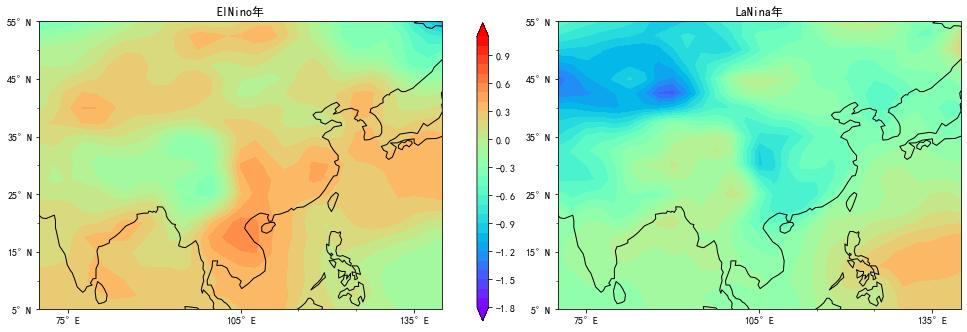

In [21]:
lon=air.lon.data
lat=air.lat.data
# 合成分析绘图
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_axes([0.1, 0.1, 0.35, 0.8], projection=ccrs.PlateCarree(central_longitude=105))
ax2 = fig.add_axes([0.55, 0.1, 0.35, 0.8], projection=ccrs.PlateCarree(central_longitude=105))
ax3 = fig.add_axes([0.48, 0.26, 0.01, 0.46])
createmap(ax1)
createmap(ax2)
# 标题
ax1.set_title('ElNino年')
ax2.set_title('LaNina年')

# 绘图
colorbar=ax1.contourf(lon,lat,ninohe,cmap='rainbow',levels=np.arange(-1.8,1.2,0.1), transform=ccrs.PlateCarree(),zorder=0,extend='both')
plt.colorbar(colorbar,pad=0.03, fraction=0.04,shrink=0.7,cax=ax3,orientation='vertical')
ax2.contourf(lon,lat,ninahe,cmap='rainbow',levels=np.arange(-1.8,1.2,0.1), transform=ccrs.PlateCarree(),zorder=0,extend='both')

# 保存图片
plt.savefig('../../picture/pythonhome/13/qu31.png', dpi=200)

In [22]:
# 显著性检验
from scipy.stats import ttest_ind

# 1.t值
# T检验是用t分布理论来推论差异发生的概率，从而比较两个平均数的差异是否显著。
# 2.P值
# P值是用来判定假设检验结果的一个参数。
#
# P值（P value）就是当原假设为真时所得到的样本观察结果或更极端结果出现的概率。如果P值很小，说明原假设情况的发生的概率很小，而如果出现了，根据小概率原理，我们就有理由拒绝原假设，P值越小，我们拒绝原假设的理由越充分。
t_nino,_=ttest_ind(ninoair,winair,equal_var=False)
t_nina,_=ttest_ind(ninaair,winair,equal_var=False)

In [23]:
t_nina

array([[-0.4598289 , -0.4598289 , -0.4598289 , ..., -0.4598289 ,
        -0.4598289 , -0.4598289 ],
       [-0.38900534, -0.37260194, -0.35666327, ..., -0.43841887,
        -0.42094866, -0.40504659],
       [-0.40555939, -0.37780414, -0.35241049, ..., -0.49954184,
        -0.46717564, -0.43547997],
       ...,
       [-0.50474166, -0.53027541, -0.5642208 , ..., -0.45311934,
        -0.4663975 , -0.4819967 ],
       [-0.64926554, -0.64484818, -0.63901946, ..., -0.66235007,
        -0.65778643, -0.65330835],
       [-0.3039339 , -0.3039339 , -0.3039339 , ..., -0.3039339 ,
        -0.3039339 , -0.3039339 ]])

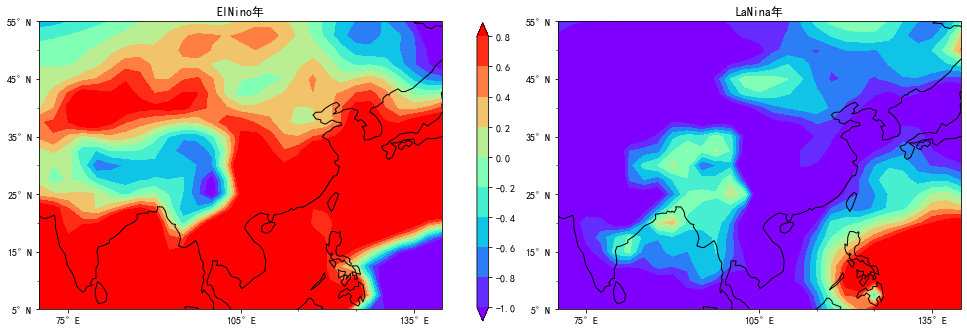

In [24]:
# 绘制显著性检验
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_axes([0.1, 0.1, 0.35, 0.8], projection=ccrs.PlateCarree(central_longitude=105))
ax2 = fig.add_axes([0.55, 0.1, 0.35, 0.8], projection=ccrs.PlateCarree(central_longitude=105))
ax3 = fig.add_axes([0.48, 0.26, 0.01, 0.46])
createmap(ax1)
createmap(ax2)
# 标题
ax1.set_title('ElNino年')
ax2.set_title('LaNina年')

# 绘图
colorbar=ax1.contourf(lon,lat,t_nino,cmap='rainbow',levels=np.arange(-1,1,0.2), transform=ccrs.PlateCarree(),zorder=0,extend='both')
plt.colorbar(colorbar,pad=0.03, fraction=0.04,shrink=0.7,cax=ax3,orientation='vertical')
ax2.contourf(lon,lat,t_nina,cmap='rainbow',levels=np.arange(-1,1,0.2), transform=ccrs.PlateCarree(),zorder=0,extend='both')

# 保存图片
plt.savefig('../../picture/pythonhome/13/qu32.png', dpi=200)